# Crowd counter
For BP purposes

Norbert Matuška

In [342]:
from __future__ import annotations

import math
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# ---------- USER CONFIG -----------------------------------------------------

In [343]:
DATA_ROOT: Path = Path("data")          # root folder with scenario sub‑dirs
SCENARIO: str = "doortodoor"                 # basic | doortodoor | handover
PEOPLE_COUNT: str = "10p"               # 10p | 25p | 50p
RUNS = [str(i) for i in range(1, 11)]   # run folders "1" … "10"

GROUND_TRUTH: int = int(PEOPLE_COUNT.rstrip("p"))  # 10 / 25 / 50

# Algorithm hyper‑parameters
SESSION_GAP = 20     # seconds – largest intra‑session gap (gap‑split / DBSCAN)
IDLE_TAIL   = 15     # seconds – pad left & right of each session
STEP_SEC    = 1      # seconds – time‑series resolution
TAU_SEC     = 200    # seconds – e‑folding time for decay filter

PLOT_DIR = Path("crowd_counting_plots") 


# ---------- HELPERS -----------------------------------------------------


In [344]:
def load_events(run_dir: Path) -> pd.DataFrame:
    """Load **events.csv** created by pcap_converter.py and enforce schema."""
    csv_path = run_dir / "events.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path} missing – did you run pcap_converter.py?")
    df = pd.read_csv(csv_path)
    if {"time", "mac"} - set(df.columns):
        raise ValueError(f"{csv_path} must have columns time, mac")
    df["mac"] = df["mac"].str.lower()
    return df

def _sessions_to_series(sessions: list[tuple[float, float]],
                        step: int,
                        name: str) -> pd.Series:
    """Convert interval list ➜ time‑series (sweep‑line algorithm)."""
    if not sessions:
        return pd.Series(dtype=float, name=name)

    sessions = np.asarray(sessions)
    t_min, t_max = sessions[:, 0].min(), sessions[:, 1].max()
    ts = np.arange(t_min, t_max + step, step)

    starts = np.sort(sessions[:, 0])
    ends   = np.sort(sessions[:, 1])
    active = i_start = i_end = 0
    counts = []
    for t in ts:
        while i_start < len(starts) and starts[i_start] <= t:
            active += 1; i_start += 1
        while i_end < len(ends) and ends[i_end] < t:
            active -= 1; i_end += 1
        counts.append(active)
    return pd.Series(counts, index=ts, name=name)

def eval_series(series: pd.Series, gt: int) -> dict[str, float]:
    med = int(round(series.median()))
    return {
        "median_est": med,
        "error": med - gt,
        "mae_ts": mean_absolute_error(np.full(series.shape, gt), series),
    }


# ---------- Crowd-size via DBSCAN sessions ----------------------------------


In [345]:
def estimate_dbscan(df: pd.DataFrame) -> pd.Series:
    """
    DBSCAN clustering of per-MAC packet times followed by tail dilation.
    Equivalent to the notebook block the user pasted earlier.
    """
    sessions: list[tuple[float, float]] = []
    for mac, grp in df.groupby("mac"):
        times = grp["time"].to_numpy().reshape(-1, 1)
        if times.size == 0:
            continue
        labels = DBSCAN(eps=SESSION_GAP, min_samples=1).fit_predict(times)
        for lab in np.unique(labels):
            seg = times[labels == lab].flatten()
            sessions.append((seg.min() - IDLE_TAIL, seg.max() + IDLE_TAIL))
    return _sessions_to_series(sessions, STEP_SEC, "dbscan_dilated")


# ---------- Crowd-size via GAP-SPLIT sessions -------------------------------


In [346]:
def estimate_gap_split(df: pd.DataFrame) -> pd.Series:
    """Crowd‑size by simple gap‑splitting + tail dilation."""
    sessions: list[tuple[float, float]] = []
    for _, grp in df.groupby("mac"):
        times = np.sort(grp["time"].to_numpy())
        if times.size == 0:
            continue
        idx = np.where(np.diff(times) > SESSION_GAP)[0] + 1
        segments = np.split(times, idx)
        for seg in segments:
            sessions.append((seg[0] - IDLE_TAIL, seg[-1] + IDLE_TAIL))
    return _sessions_to_series(sessions, STEP_SEC, "gap_split")


# ---------- Probabilistic presence filter ------------------------------
Each MAC's “presence weight” decays exponentially with time-constant τ.
Whenever the MAC is heard, its weight is reset to 1.
Crowd estimate at time t  =  Σ  weights.

In [347]:
def estimate_decay(df: pd.DataFrame) -> pd.Series:
    """Crowd‑size by exponential‑decay presence filter."""
    t_max = df["time"].max()
    ts = np.arange(0, t_max + STEP_SEC, STEP_SEC)
    df["slot"] = (df["time"] // STEP_SEC).astype(int)
    pkts = df.groupby("slot")["mac"].apply(list)

    decay = math.exp(-STEP_SEC / TAU_SEC)
    weights: defaultdict[str, float] = defaultdict(float)
    counts = []
    for slot in range(len(ts)):
        # decay
        for m in list(weights):
            weights[m] *= decay
            if weights[m] < 1e-4:
                weights.pop(m)
        # boost
        for m in pkts.get(slot, []):
            weights[m] = 1.0
        counts.append(sum(weights.values()))
    return pd.Series(counts, index=ts, name="decay")

# ---------- Support-Vector Regression ------------------------------

In [348]:
def estimate_svr(df: pd.DataFrame, silver: pd.Series) -> pd.Series:
    """Support‑Vector Regression borrowing the gap‑split series as context."""
    t_max = df["time"].max()
    ts = np.arange(0, t_max + STEP_SEC, STEP_SEC)

    df["slot"] = (df["time"] // STEP_SEC).astype(int)
    pkts = df.groupby("slot")["mac"].apply(list)

    feat = defaultdict(list)
    silver_full = silver.reindex(ts, fill_value=0)   # <── padded copy
    for slot in range(len(ts)):
        macs = pkts.get(slot, [])
        feat["pkt_cnt"].append(len(macs))
        feat["uniq_macs"].append(len(set(macs)))
        feat["sess_active"].append(silver_full.iloc[slot])

    X = np.vstack([feat["pkt_cnt"], feat["uniq_macs"], feat["sess_active"]]).T
    y = silver_full.values.astype(float)

    split = int(0.8 * len(X))
    svr = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10.0, epsilon=0.5))
    svr.fit(X[:split], y[:split])
    y_pred = svr.predict(X)
    return pd.Series(y_pred, index=ts, name="svr")


# ---------- PCA-assisted k-means clustering ------------------------------

In [349]:
def estimate_kmeans(df: pd.DataFrame, silver: pd.Series) -> pd.Series:
    """PCA + k‑means clustering on engineered features."""
    t_max = df["time"].max()
    ts = np.arange(0, t_max + STEP_SEC, STEP_SEC)

    df["slot"] = (df["time"] // STEP_SEC).astype(int)
    pkts = df.groupby("slot")["mac"].apply(list)

    feat = defaultdict(list)
    silver_full = silver.reindex(ts, fill_value=0)   # <── padded copy
    for slot in range(len(ts)):
        macs = pkts.get(slot, [])
        feat["pkt_cnt"].append(len(macs))
        feat["uniq_macs"].append(len(set(macs)))
        feat["sess_active"].append(silver_full.iloc[slot])

    X = np.vstack([feat["pkt_cnt"], feat["uniq_macs"], feat["sess_active"]]).T
    X_scaled = StandardScaler().fit_transform(X)
    X_emb = PCA(n_components=0.95, svd_solver="full").fit_transform(X_scaled)

    km = KMeans(n_clusters=3, n_init="auto", random_state=42)
    labels = km.fit_predict(X_emb)

    # use the *padded* silver_full when deriving the cluster → crowd‑size map
    cluster2cnt = {}
    for c in range(3):
        idx = labels == c
        cluster2cnt[c] = int(round(np.median(silver_full.values[idx]))) if idx.any() else 0
    preds = np.vectorize(cluster2cnt.get)(labels)
    return pd.Series(preds, index=ts, name="kmeans")

### Pre-run processing

In [350]:
def analyze_run(run_dir: Path, gt: int) -> dict:
    df = load_events(run_dir)
    
    start = time.perf_counter()
    dbs = estimate_dbscan(df)
    dbs_time = time.perf_counter() - start
    
    start = time.perf_counter()
    gap = estimate_gap_split(df)
    gap_time = time.perf_counter() - start
    
    start = time.perf_counter()
    decay = estimate_decay(df)
    decay_time = time.perf_counter() - start
    
    start = time.perf_counter()
    svr = estimate_svr(df, gap)
    svr_time = time.perf_counter() - start
    
    start = time.perf_counter()
    km = estimate_kmeans(df, gap)
    km_time = time.perf_counter() - start
    
    return {
        "run": run_dir.name,
        "_series": {
        "dbscan": dbs, "gap": gap, "decay": decay, "svr": svr, "kmeans": km
        },
        "dbscan_time": dbs_time,
        "gap_time":    gap_time,
        "decay_time":  decay_time,
        "svr_time":    svr_time,
        "kmeans_time": km_time,
        "dbscan_dilated": eval_series(dbs, gt),
        "gap_split": eval_series(gap, gt),
        "decay": eval_series(decay, gt),
        "svr": eval_series(svr, gt),
        "kmeans": eval_series(km, gt),
    }

### Aggregation & visualisation

In [351]:
def flatten(metrics: list[dict]) -> pd.DataFrame:
    """
    Convert a list of per-run metric dicts into a flat DataFrame
    with one row per run‐algorithm, including both eval metrics
    and the corresponding runtime in seconds.
    """
    rows = []
    for m in metrics:
        run = m["run"]
        for algo, vals in m.items():
            if algo in ("run", "_series"):
                continue
            if not isinstance(vals, dict):
                continue

            row = {"run": run, "algorithm": algo}
            row.update(vals)

            prefix = algo.split("_")[0]
            row["time_sec"] = m.get(f"{prefix}_time")

            rows.append(row)

    return pd.DataFrame(rows)

def plot_error_box(df: pd.DataFrame):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="algorithm", y="error", data=df, showfliers=False)
    sns.swarmplot(x="algorithm", y="error", data=df, size=3, color=".25")
    plt.axhline(0, ls="--", lw=1)
    plt.title("Median error distribution across runs")
    plt.tight_layout()
    
    _save_current_fig("median_error")

def plot_mae_heatmap(df: pd.DataFrame):
    pivot = df.pivot(index="run", columns="algorithm", values="mae_ts")
    plt.figure(figsize=(6, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="crest", cbar_kws={"label": "MAE"})
    plt.title("Per-run MAE (time-series)")
    plt.tight_layout()
    
    _save_current_fig("mae_heatmap")

def plot_temporal_envelope(run_series: dict[str, list[pd.Series]],
                           time_lim: tuple[int, int] | None = None):
    """
    run_series["gap_split"] = [Series_run1, Series_run2, …]

    time_lim  – (t_start, t_end) in seconds, or None for full axis
    """
    plt.figure(figsize=(10, 4))

    for alg, series_list in run_series.items():
        df = pd.concat(series_list, axis=1)

        if time_lim is not None:
            t0, t1 = time_lim
            df = df.loc[(df.index >= t0) & (df.index <= t1)]

        median = df.median(axis=1)
        q1     = df.quantile(0.25, axis=1)
        q3     = df.quantile(0.75, axis=1)

        plt.plot(median.index, median, label=alg)
        plt.fill_between(median.index, q1, q3, alpha=.15)

    if time_lim is not None:
        plt.xlim(*time_lim)

    plt.axhline(GROUND_TRUTH, color="k", ls="--", lw=1, alpha=.6, label="Ground truth")
    plt.xlabel("Simulation time [s]")
    plt.ylabel("People")
    plt.title(f"Temporal median estimate +- IQR band ({SCENARIO} scenario)")
    plt.legend()
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
    plt.tight_layout()
    
    _save_current_fig("temporal_envelope")

def plot_gt_vs_estimate(df: pd.DataFrame, gt: int):
    """
    One bar per algorithm = median of its 10‑run median estimates.
    Grey bar (ground truth) behind for easy comparison.
    """
    medians = (
        df.groupby("algorithm")["median_est"]
        .mean()
        .sort_index()
    )

    xpos = np.arange(len(medians))
    width = 0.5

    plt.figure(figsize=(6, 4))
    # GT bar (same width, light grey)
    plt.bar(xpos, [gt] * len(medians), width,
            color="lightgrey", label="ground truth")
    # overlay algorithm bars (slightly narrower so the grey peeks)
    plt.bar(xpos, medians.values, width * 0.7,
            label="algorithm estimate")
    plt.xticks(xpos, medians.index, rotation=20)
    plt.ylabel("People")
    plt.title(f"Median estimate vs ground truth ({SCENARIO} scenario)")
    plt.legend()
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
    plt.tight_layout()
    
    _save_current_fig("gt_vs_estimate")

def _save_current_fig(basename: str, dpi: int = 300):
    """
    Save the active Matplotlib figure to *folder* with a name that encodes
    scenario + people‑count, e.g.
        median_error_basic_25p.png
    """
    scenario_dir = PLOT_DIR / SCENARIO
    scenario_dir.mkdir(parents=True, exist_ok=True)

    fname = f"{PEOPLE_COUNT}_{SCENARIO}_{basename}.png"
    PLOT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(scenario_dir / fname, dpi=dpi, bbox_inches="tight")


Ground‑truth | head‑count = 50 | scenario = handover
                median_est (10 runs)  mean error  mean MAE  mean runtime (s)
algorithm                                                                   
dbscan_dilated                  24.0       -26.0     23.20             22.40
decay                           48.0        -2.0      2.53              0.04
gap_split                       24.0       -26.0     23.20              0.04
kmeans                          21.0       -29.0     22.70              0.04
svr                             25.0       -25.0     23.66              0.03


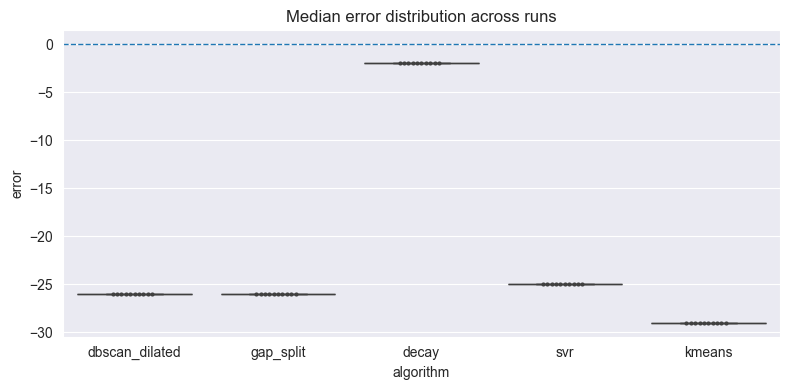

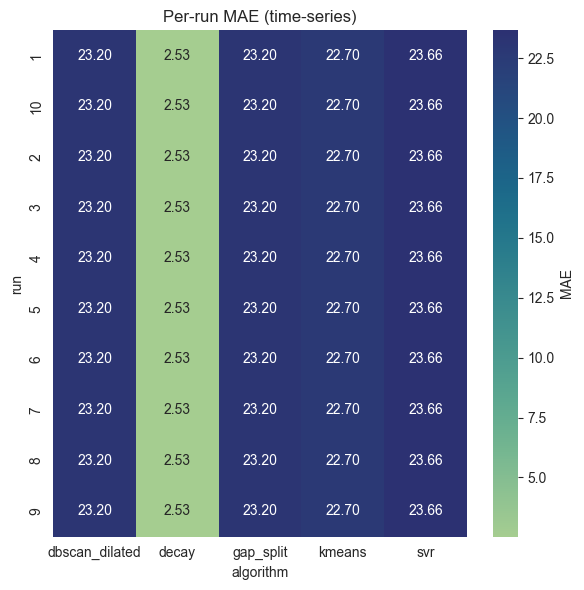

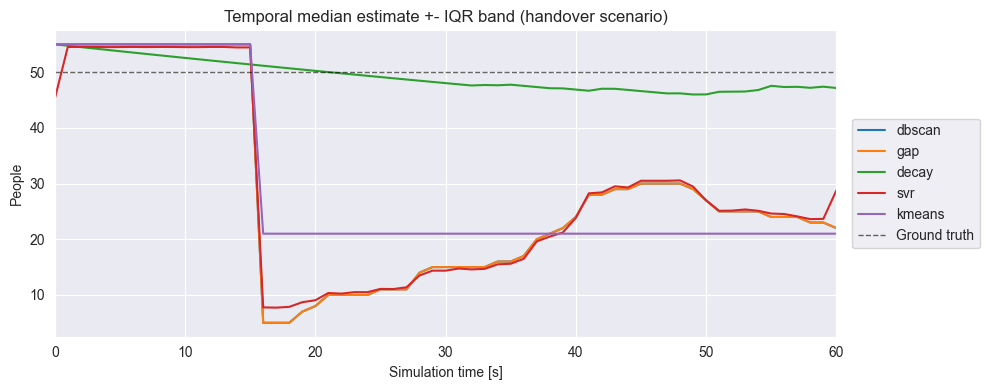

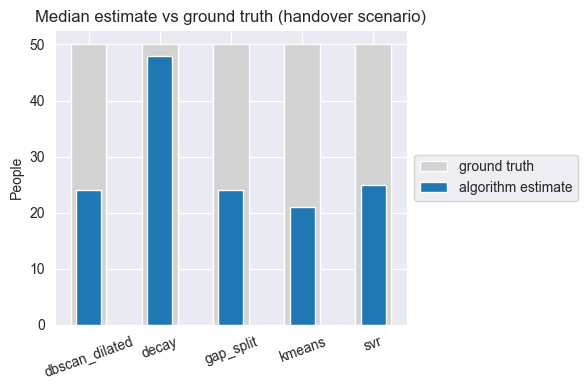

In [352]:
def main():
    run_base = DATA_ROOT / SCENARIO / PEOPLE_COUNT
    all_metrics = []
    series_by_alg = defaultdict(list)
    for run in RUNS:
        run_dir = run_base / run
        if not run_dir.exists():
            print(f"[WARN] {run_dir} missing – skipping")
            continue
        all_metrics.append(analyze_run(run_dir, GROUND_TRUTH))
    
    if not all_metrics:
        print("No runs processed – check folder names")
        return
    
    res = analyze_run(run_dir, GROUND_TRUTH)
    for alg, s in res["_series"].items():
        series_by_alg[alg].append(s)
        
    df_metrics = flatten(all_metrics)
    summary = (
        df_metrics
        .groupby("algorithm")[
            ["median_est", "error", "mae_ts", "time_sec"]
        ]
        .mean()
        .round(2)
        .rename(columns={
            "median_est": "median_est (10 runs)",
            "error":      "mean error",
            "mae_ts":     "mean MAE",
            "time_sec":   "mean runtime (s)"
        })
    )
    
    print(f"\nGround‑truth | head‑count = {GROUND_TRUTH} | scenario = {SCENARIO}")
    print(summary)

    plot_error_box(df_metrics)
    plot_mae_heatmap(df_metrics)
    plot_temporal_envelope(series_by_alg, time_lim=(0, 60))
    plot_gt_vs_estimate(df_metrics, GROUND_TRUTH)
    plt.show()

main()